In [1]:
import os.path as osp
import time

import torch
import numpy as np
import random
import itertools
import networkx as nx
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: cpu


## FUNCTIONS

In [3]:
def graphToEdgelist(g):
    """
    Returns the edge list of a networkx graph.
    Note that if the graph is undirected, the first node in the edge list has always the smaller index.
    g: networkx graph
    """
    edges = list(g.edges())

    # From edge list to a PyTorch tensor
    edge_index = torch.tensor(list(zip(*edges)), dtype=torch.long)

    return edge_index


def graphToNonEdgelist(g):
    """
    Returns the non-edge list of a networkx graph.
    g: networkx graph
    """
    not_edges = list(nx.non_edges(g))

    # From edge list to a PyTorch tensor
    not_edge_index = torch.tensor(list(zip(*not_edges)), dtype=torch.long)

    return not_edge_index


def graphToEdgeLabel(g, k):
    """
    Returns k edges and k not edges to be tested.
    g: networkx graph
    k: number of edges to be labeled
    """
    # Get the edges and the not edges
    edges = list(nx.edges(g))
    not_edges = list(nx.non_edges(g))
    assert len(edges) > k, "k must be smaller than the number of edges"

    # Choose randomly k edges and k not edges
    true_edges_index = np.random.choice(len(edges), size=k, replace=False)
    true_not_edges_index = np.random.choice(len(not_edges), size=k, replace=False)

    true_edges = [edges[i] for i in true_edges_index]
    true_not_edges = [not_edges[i] for i in true_not_edges_index]

    # Cast them to a torch tensor
    true_edges_index = torch.tensor(list(zip(*true_edges)), dtype=torch.long)
    true_not_edges_index = torch.tensor(list(zip(*true_not_edges)), dtype=torch.long)

    # Merge the tensors
    edge_label_index = torch.cat([true_edges_index, true_not_edges_index], dim=1)

    # Create the labels
    edge_label = torch.cat([torch.ones(k), torch.zeros(k)], dim=0)

    # Shuffle the tensor
    shuffle = torch.randperm(edge_label_index.size(1))
    edge_label_index = edge_label_index[:, shuffle]
    edge_label = edge_label[shuffle]

    return edge_label_index, edge_label


def sigmoid(z):
    return 1/(1 + np.exp(-z))


def getAllPairs(N):
    """
    Returns all the pairs of nodes in a undirected graph.
    N: number of nodes
    """
    pairs = list(itertools.combinations(range(N), 2))
    pairs_tensor = torch.tensor(pairs).t()

    return pairs_tensor


def edgelistToGraph(edge_list):
    """
    Returns a networkx graph from an edge list.
    edge_list: list of edges (tensor)
    """
    edge_list = edge_list.t().tolist()
    g = nx.Graph()
    g.add_edges_from(edge_list)
    return g

def corruptNetwork(g, f):
    """
    Corrupts a network by adding/removing edges.
    g: networkx graph
    f: corruption probability
    """
    g = g.copy()

    # Get the list of edges and non-edges of g
    edges = list(g.edges())
    not_edges = list(nx.non_edges(g))

    # Number of edges to be added/removed
    num_corrupted = int(np.floor(f * len(edges)))

    # Randomly select edges to remove
    edges_to_remove = random.sample(edges, num_corrupted)
    g.remove_edges_from(edges_to_remove)

    # Randomly select edges to add
    edges_to_add = random.sample(not_edges, num_corrupted)
    g.add_edges_from(edges_to_add)

    return g

## GRAPH NETWORK ENCODE DECODE

In [4]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        ## Check cached option for transductive learning
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.reset_parameters()  # Initialize weights

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        z = self.conv2(x, edge_index)
        return z

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        # prob_adj = torch.sigmoid(raw_adj)
        return (prob_adj > 0).nonzero(as_tuple=False).t()

## PLANETOID DATASET

Planetoid[0] ha come classi le malattie che sono trattate dai nodi (articoli scientifici), gli edges sono citazioni tra articoli
Le features di ciascun nodo sono derivate dal testo dell'articolo. Sono rappresentate da un vettore sparso che descrive la presenza di parole chiave (termine) nell'articolo (valori numerici che rappresentano una frequenza normalizzata)

We set add_negative_train_samples to False and then do the negative sampling alone because when you have very few edges, and adding negative samples might lead to confusion during training

In [5]:
transform = T.Compose([
    T.NormalizeFeatures(), # normalize the features of the nodes
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, # divide graph in training, validation and test
                      add_negative_train_samples=False),
])

dataset = Planetoid("./data/", name='PubMed', transform=transform)

# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data,
#  val_data, test_data), with
# each element representing the corresponding split.

train_data, val_data, test_data = dataset[0]

g_train = nx.from_edgelist(train_data.edge_index.t().tolist())
g_val = nx.from_edgelist(val_data.edge_index.t().tolist())
g_test = nx.from_edgelist(test_data.edge_index.t().tolist())


c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

In [6]:
unique_classes, counts = torch.unique(train_data.edge_label, return_counts=True)
print(f"Unique classes: {unique_classes}, Counts: {counts}")

Unique classes: tensor([1.]), Counts: tensor([37676])


In [7]:
print(dataset)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of node features:\t",dataset.num_node_features)
print("number of edge features:\t",dataset.num_edge_features)

PubMed()
number of graphs:		 1
number of classes:		 3
number of node features:	 500
number of edge features:	 0


In [8]:
print("edge_index:\t\t",dataset.data.edge_index.shape) # edge list, shape (2, #edges)
print(dataset.data.edge_index)
print("\n")
print("train_mask:\t\t",dataset.data.train_mask.shape)
print(dataset.data.train_mask)
print("\n")
print("x:\t\t",dataset.data.x.shape) # node feature matrix, shape (#nodes, #feature)
print(dataset.data.x)
print("\n")
print("y:\t\t",dataset.data.y.shape) # node labels, shape (#nodes)
print(dataset.data.y)

edge_index:		 torch.Size([2, 88648])
tensor([[ 1378,  1544,  6092,  ..., 12278,  4284, 16030],
        [    0,     0,     0,  ..., 19714, 19715, 19716]])


train_mask:		 torch.Size([19717])
tensor([ True,  True,  True,  ..., False, False, False])


x:		 torch.Size([19717, 500])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1046, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0194, 0.0080,  ..., 0.0000, 0.0000, 0.0000],
        [0.1078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0266, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


y:		 torch.Size([19717])
tensor([1, 1, 0,  ..., 2, 0, 2])


c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [9]:
model = Net(dataset.num_features, 128, 64).to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [10]:
train_data.x.shape

torch.Size([19717, 500])

E' possibile corrompere il network, ma su un network con così tanti nodi il computing time è davvero alto, 150 volte più grande di quello necessario per il training. L'algoritmo si vede che è di una complessità diversa. Quello che ho rifatto sopra è migliora ma ancora scala troppo male con il numero di nodi

In [11]:
def train(train_data, g_train=g_train, corrupt=False, corrupt_percentage=0.1):
    model.train()
    optimizer.zero_grad()

    if corrupt:
        # Corrupt the network if the corrupt flag is set to True
        g_corrupted = corruptNetwork(g_train, corrupt_percentage)
        print("The network has been corrupted.")

        # Transformation to edge list
        train_edge_index_corrupted = graphToEdgelist(g_corrupted)
    else:
        # If corrupt is False, use the original network
        train_edge_index_corrupted = train_data.edge_index

    # Encoding
    z = model.encode(train_data.x, train_edge_index_corrupted)

    # Negative sampling
    neg_edge_index = negative_sampling(
        edge_index=train_edge_index_corrupted, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    # Edge label creation
    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data.edge_label,
                             train_data.edge_label.new_zeros(neg_edge_index.size(1))],
                            dim=0)

    # Shuffling
    shuffle = torch.randperm(edge_label_index.size(1))
    edge_label_index = edge_label_index[:, shuffle]
    edge_label = edge_label[shuffle]

    # Decoding
    out = model.decode(z, edge_label_index).view(-1)

    # Loss computation and backpropagation
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    
    preds = (out > 0.5).float()  
    accuracy = (preds == edge_label).float().mean().item()  

    return loss, accuracy  


add_negative_train_samples, questo parametro settato a True ti mette gli edges che sai che non esistono direttamente nel train set.
Così facendo però sia encode che decodo usano negative samples, se invece lo setto a False posso fare il negative sample dopo l'encoding e fare l'encoding con solo positive sample e decoding con anche negative sample. 
Da provare a runnare cambiando questo e vedere cosa succede facendo con entrambe negative samples cosa succede.

In [12]:
loss, train_accuracy = train(train_data)
print(loss)
print(train_accuracy)

tensor(0.6928, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
0.5


In [12]:
@torch.no_grad()
def test(data, g_test, corrupt=False, corrupt_percentage=0.1, full_output=False):
    model.eval()

    if corrupt:
        g_corrupted = corruptNetwork(g_test, corrupt_percentage)
        test_edge_index_corrupted = graphToEdgelist(g_corrupted)
        print(f"The network has been corrupted with {corrupt_percentage * 100}% corruption.")
    else:
        test_edge_index_corrupted = data.edge_index

    # Encoding
    z = model.encode(data.x, test_edge_index_corrupted)

    # Decoding using test edge_label_index
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    # Evaluate score
    out_cpu = out.cpu().numpy()
    label_cpu = data.edge_label.cpu().numpy()

    # Shuffle
    # shuffle = torch.randperm(out_cpu.shape[0])
    # out_cpu = out_cpu[shuffle]
    # label_cpu = label_cpu[shuffle]

    # Calculate accuracy
    preds = (out > 0.5).float()  # Assuming a threshold of 0.5
    accuracy = (preds.cpu().numpy() == label_cpu).mean().item()    # Calculate accuracy

    # Compute AUC score (optional)
    auc = roc_auc_score(label_cpu, out_cpu)

    # Return results based on full_output flag
    if full_output:
        return accuracy, auc, out_cpu, label_cpu
    else:
        return accuracy, auc


In [13]:
unique_classes, counts = torch.unique(train_data.edge_label, return_counts=True)
print(f"Unique classes: {unique_classes}, Counts: {counts}")

Unique classes: tensor([1.]), Counts: tensor([37676])


In [14]:
def train_model(train_data, val_data, test_data, epochs=100, early_stopping=False, early_stopping_patience=10, corrupt=False, corrupt_percentage=0.1, training_percentage=1):
    best_val_auc = 0
    val_history = []
    auc_history = []
    loss_history = []
    train_accuracy_history = []  # Lista per memorizzare l'accuratezza di addestramento
    best_epoch = 0
    early_stopping_counter = 0

    total_train_time = 0
    total_val_time = 0


    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")

        # Start timing for the training part
        train_start_time = time.time()

        # Training
        model.train()
        loss, train_accuracy = train(train_data, corrupt=corrupt, corrupt_percentage=corrupt_percentage)

        # End timing for the training part
        train_duration = time.time() - train_start_time
        total_train_time += train_duration
        print(f"Training completed in {train_duration:.4f} seconds.")

        # Start timing for the validation part
        val_start_time = time.time()

        # Validation
        val_acc, val_auc = test(val_data, g_val, corrupt=corrupt, corrupt_percentage=corrupt_percentage)

        # End timing for the validation part
        val_duration = time.time() - val_start_time
        total_val_time += val_duration
        print(f"Validation completed in {val_duration:.4f} seconds.")

        # Store metrics
        val_history.append(val_acc)
        auc_history.append(val_auc)
        loss_history.append(loss.cpu().detach().numpy())
        train_accuracy_history.append(train_accuracy)  # Salva l'accuratezza di addestramento

        # Check if the current validation AUC is the best
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_epoch = epoch
            early_stopping_counter = 0

        else:
            early_stopping_counter += 1

        # Print metrics for the current epoch
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_accuracy:.4f}, Val AUC: {val_auc:.4f}, Val ACC: {val_acc:.4f}')

        # Early stopping condition (only if early_stopping is enabled)
        if early_stopping and early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch}.")
            break

    # Final evaluation on the test set
    final_test_acc, final_test_auc = test(test_data, g_test, corrupt=corrupt, corrupt_percentage=corrupt_percentage)
    print(f'Final Test AUC: {final_test_auc:.4f}')
    print(f'Final Test ACC: {final_test_acc:.4f}')

    


    # Final encoding and decoding (remove if not needed)
    z = model.encode(test_data.x, test_data.edge_index)
    final_edge_index = model.decode_all(z)

    print(f"Total training time: {total_train_time:.4f} seconds.")
    print(f"Total validation time: {total_val_time:.4f} seconds.")

    return val_history, auc_history, loss_history, final_test_auc, final_test_acc, train_accuracy_history  # Restituisci anche l'accuratezza di addestramento


In [16]:
val_history, auc_history, loss_history, final_test_auc, final_test_acc, train_accuracy_history = train_model(train_data, val_data, test_data, epochs=300)

Epoch 1/300
Training completed in 0.2390 seconds.
Validation completed in 0.0620 seconds.
Epoch: 001, Loss: 0.6883, Train Acc: 0.5000, Val AUC: 0.8912, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.2290 seconds.
Validation completed in 0.0570 seconds.
Epoch: 002, Loss: 0.6702, Train Acc: 0.5226, Val AUC: 0.8926, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.2470 seconds.
Validation completed in 0.0550 seconds.
Epoch: 003, Loss: 0.6731, Train Acc: 0.7512, Val AUC: 0.8956, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.2236 seconds.
Validation completed in 0.0620 seconds.
Epoch: 004, Loss: 0.6550, Train Acc: 0.8086, Val AUC: 0.8940, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.2695 seconds.
Validation completed in 0.0626 seconds.
Epoch: 005, Loss: 0.6556, Train Acc: 0.6360, Val AUC: 0.8880, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.2323 seconds.
Validation completed in 0.0540 seconds.
Epoch: 006, Loss: 0.6529, Train Acc: 0.6241, Val AUC: 0.8829, Val ACC:

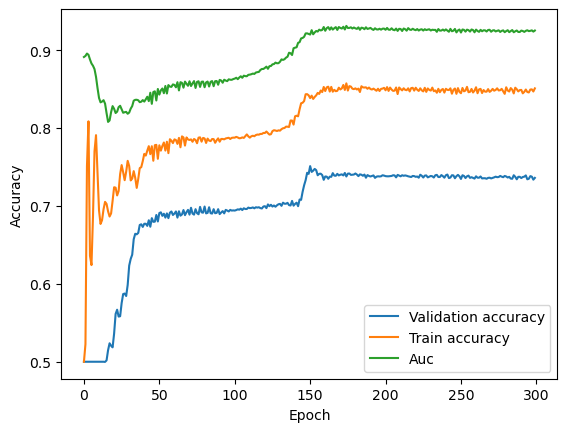

In [17]:
plt.plot(val_history, label="Validation accuracy")
plt.plot(train_accuracy_history, label="Train accuracy")
plt.plot(auc_history, label="Auc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

Text(0, 0.5, 'Accuracy')

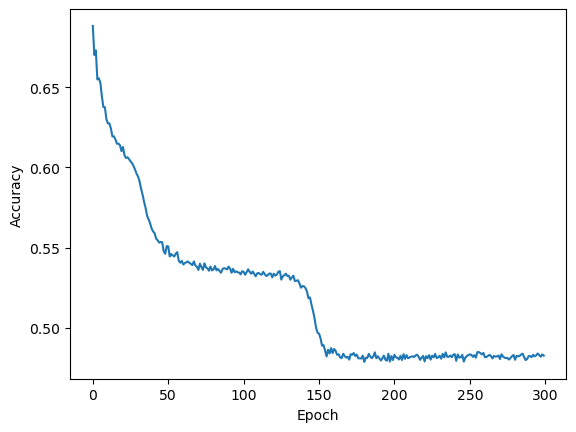

In [18]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Generally as a instrument to asses the quality of the algorithm when is AU, it's better when the elements of one class are much more than the ones of the other one

In [24]:
test_accuracy_auc_mean = []
test_accuracy_auc_std = []
test_accuracy_acc_mean = []
test_accuracy_acc_std = []

percentages = [0.5, 0.6, 0.7, 0.8, 0.9]

for i in percentages:
    auc_scores = []
    acc_scores = []
    
    for _ in range(5): 
        transform = T.Compose([
            T.NormalizeFeatures(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=1-0.05-i, is_undirected=True,
                              add_negative_train_samples=False),
        ])
        
        dataset = Planetoid("./data/", name='PubMed', transform=transform)
        train_data, val_data, test_data = dataset[0]
        
        g_train = nx.from_edgelist(train_data.edge_index.t().tolist())
        g_val = nx.from_edgelist(val_data.edge_index.t().tolist())
        g_test = nx.from_edgelist(test_data.edge_index.t().tolist())
        
        _, _, _, final_test_auc, final_test_acc, _ = train_model(train_data, val_data, test_data)
        
        # Collect results
        auc_scores.append(final_test_auc)
        acc_scores.append(final_test_acc)
    
    # Compute mean and std for AUC and accuracy for each percentage
    test_accuracy_auc_mean.append(np.mean(auc_scores))
    test_accuracy_auc_std.append(np.std(auc_scores))
    test_accuracy_acc_mean.append(np.mean(acc_scores))
    test_accuracy_acc_std.append(np.std(acc_scores))

Epoch 1/100
Training completed in 0.1990 seconds.
Validation completed in 0.0570 seconds.
Epoch: 001, Loss: 0.5053, Train Acc: 0.8106, Val AUC: 0.8915, Val ACC: 0.7324
Epoch 2/100
Training completed in 0.1730 seconds.
Validation completed in 0.0510 seconds.
Epoch: 002, Loss: 0.5049, Train Acc: 0.8227, Val AUC: 0.8973, Val ACC: 0.7277
Epoch 3/100
Training completed in 0.1830 seconds.
Validation completed in 0.0570 seconds.
Epoch: 003, Loss: 0.4981, Train Acc: 0.8253, Val AUC: 0.8985, Val ACC: 0.7245
Epoch 4/100
Training completed in 0.1610 seconds.
Validation completed in 0.0610 seconds.
Epoch: 004, Loss: 0.4983, Train Acc: 0.8242, Val AUC: 0.8938, Val ACC: 0.7292
Epoch 5/100
Training completed in 0.1710 seconds.
Validation completed in 0.0490 seconds.
Epoch: 005, Loss: 0.5018, Train Acc: 0.8319, Val AUC: 0.8950, Val ACC: 0.7277
Epoch 6/100
Training completed in 0.2490 seconds.
Validation completed in 0.0540 seconds.
Epoch: 006, Loss: 0.5018, Train Acc: 0.8335, Val AUC: 0.8978, Val ACC:

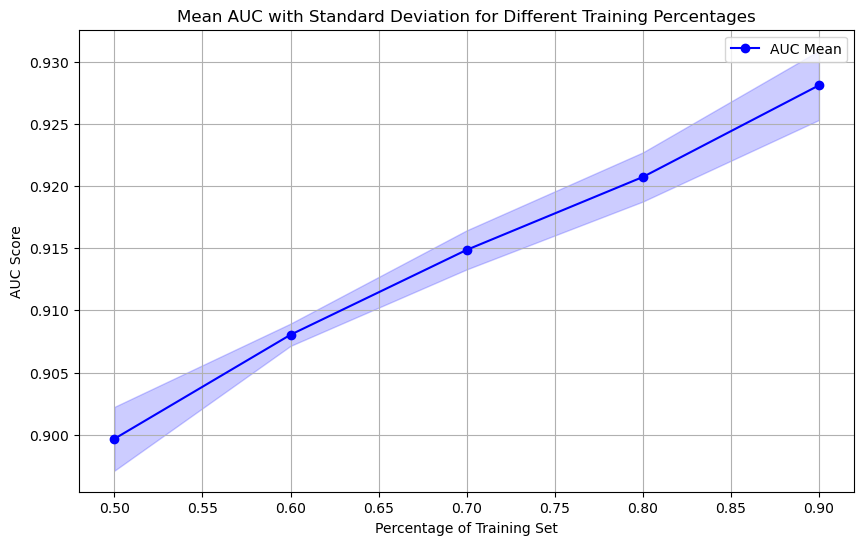

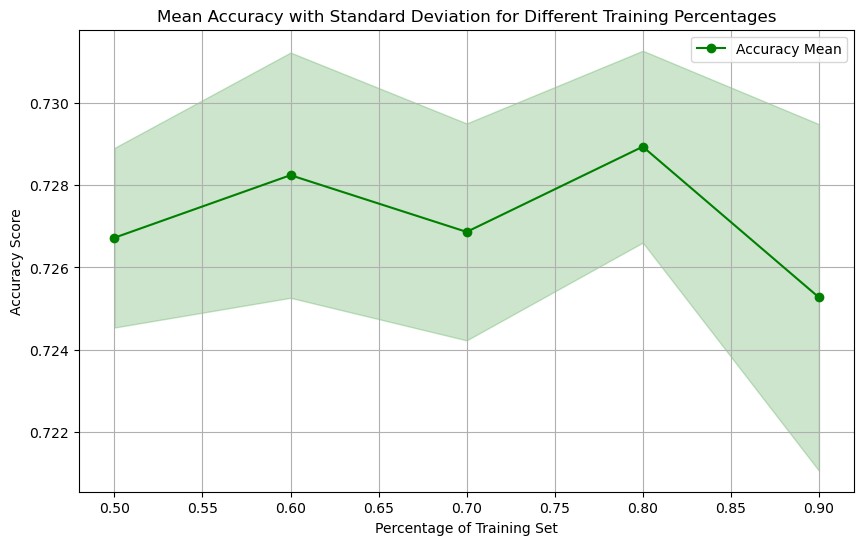

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(percentages, test_accuracy_auc_mean, label='AUC Mean', color='blue', marker='o')
plt.fill_between(percentages, 
                 np.array(test_accuracy_auc_mean) - np.array(test_accuracy_auc_std),
                 np.array(test_accuracy_auc_mean) + np.array(test_accuracy_auc_std),
                 color='blue', alpha=0., legend='AUC Std')
plt.xlabel('Percentage of Training Set')
plt.ylabel('AUC Score')
plt.title('Mean AUC with Standard Deviation for Different Training Percentages')
plt.grid(True)
plt.legend()

# Plotting Accuracy results with shaded standard deviation area
plt.figure(figsize=(10, 6))
plt.plot(percentages, test_accuracy_acc_mean, label='Accuracy Mean', color='green', marker='o')
plt.fill_between(percentages, 
                 np.array(test_accuracy_acc_mean) - np.array(test_accuracy_acc_std),
                 np.array(test_accuracy_acc_mean) + np.array(test_accuracy_acc_std),
                 color='green', alpha=0.2, legend='Accuracy Std')
plt.xlabel('Percentage of Training Set')
plt.ylabel('Accuracy Score')
plt.title('Mean Accuracy with Standard Deviation for Different Training Percentages')
plt.grid(True)
plt.legend()

## PROBLEM, DONT KNOW HOW TO AVOID OVERFITTING AND WHEN WE ARE OVERFITTING
Sarebbe da usare l'au come indice se sto trainando bene ma non so quando overfitto o meno, però non posso calcolarla durante il train
Non so se sarebbe meglio guardare le losses magari rispetto alle accuracy

## NETWORK CORA

In [10]:
transform = T.Compose([
    T.NormalizeFeatures(), # normalize the features of the nodes
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, # divide graph in training, validation and test
                      add_negative_train_samples=False),
])

dataset = Planetoid("./data/", name='Cora', transform=transform)

train_data, val_data, test_data = dataset[0]

g_train = nx.from_edgelist(train_data.edge_index.t().tolist())
g_val = nx.from_edgelist(val_data.edge_index.t().tolist())
g_test = nx.from_edgelist(test_data.edge_index.t().tolist())

In [11]:
print(dataset)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of node features:\t",dataset.num_node_features)
print("number of edge features:\t",dataset.num_edge_features)

Cora()
number of graphs:		 1
number of classes:		 7
number of node features:	 1433
number of edge features:	 0


In [12]:
print("edge_index:\t\t",dataset.data.edge_index.shape) # edge list, shape (2, #edges)
print(dataset.data.edge_index)
print("\n")
print("train_mask:\t\t",dataset.data.train_mask.shape)
print(dataset.data.train_mask)
print("\n")
print("x:\t\t",dataset.data.x.shape) # node feature matrix, shape (#nodes, #feature)
print(dataset.data.x)
print("\n")
print("y:\t\t",dataset.data.y.shape) # node labels, shape (#nodes)
print(dataset.data.y)

edge_index:		 torch.Size([2, 10556])
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])


train_mask:		 torch.Size([2708])
tensor([ True,  True,  True,  ..., False, False, False])


x:		 torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


y:		 torch.Size([2708])
tensor([3, 4, 4,  ..., 3, 3, 3])


c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [13]:
model = Net(dataset.num_features, 128, 64).to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [14]:
train_data.x.shape

torch.Size([2708, 1433])

In [15]:
loss, train_accuracy = train(train_data)
print(loss)
print(train_accuracy)

tensor(0.6930, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
0.5


In [16]:
val_history, auc_history, loss_history, final_test_auc, final_test_acc, train_accuracy_history = train_model(train_data, val_data, test_data, epochs=300)

Epoch 1/300
Training completed in 0.0500 seconds.
Validation completed in 0.0084 seconds.
Epoch: 001, Loss: 0.6906, Train Acc: 0.5000, Val AUC: 0.6736, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0164 seconds.
Validation completed in 0.0059 seconds.
Epoch: 002, Loss: 0.6837, Train Acc: 0.5099, Val AUC: 0.6727, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0155 seconds.
Validation completed in 0.0062 seconds.
Epoch: 003, Loss: 0.6847, Train Acc: 0.6639, Val AUC: 0.6740, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0147 seconds.
Validation completed in 0.0057 seconds.
Epoch: 004, Loss: 0.6785, Train Acc: 0.5702, Val AUC: 0.6746, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0151 seconds.
Validation completed in 0.0051 seconds.
Epoch: 005, Loss: 0.6788, Train Acc: 0.5271, Val AUC: 0.6732, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0141 seconds.
Validation completed in 0.0061 seconds.
Epoch: 006, Loss: 0.6771, Train Acc: 0.5282, Val AUC: 0.6714, Val ACC:

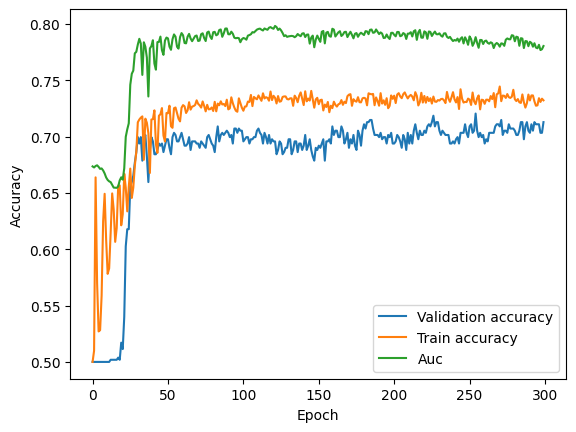

In [17]:
plt.plot(val_history, label="Validation accuracy")
plt.plot(train_accuracy_history, label="Train accuracy")
plt.plot(auc_history, label="Auc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

Come interpretiamo? Stiamo overfittando dopo le 50 epochs? Rimane sempre che il valore della accuracy è estremamente oscillante
Mi aspetterei che con questo network Cora, siccome abiamo meno nodi, ma più features per nodo dovrebbe raggiungee prestazioni migliori, ma a quanto pare non funziona così bene

In [18]:
test_accuracy_auc_mean = []
test_accuracy_auc_std = []
test_accuracy_acc_mean = []
test_accuracy_acc_std = []

percentages = [0.5, 0.6, 0.7, 0.8, 0.9]

for i in percentages:
    auc_scores = []
    acc_scores = []
    
    for _ in range(5): 
        transform = T.Compose([
            T.NormalizeFeatures(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=1-0.05-i, is_undirected=True,
                              add_negative_train_samples=False),
        ])
        
        dataset = Planetoid("./data/", name='PubMed', transform=transform)
        train_data, val_data, test_data = dataset[0]
        
        g_train = nx.from_edgelist(train_data.edge_index.t().tolist())
        g_val = nx.from_edgelist(val_data.edge_index.t().tolist())
        g_test = nx.from_edgelist(test_data.edge_index.t().tolist())

        transform = T.Compose([
            T.NormalizeFeatures(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=1-0.05-i, is_undirected=True,
                                add_negative_train_samples=False),
        ])

        dataset = Planetoid("./data/", name='Cora', transform=transform)
        train_data, val_data, test_data = dataset[0]

        g_train = nx.from_edgelist(train_data.edge_index.t().tolist())
        g_val = nx.from_edgelist(val_data.edge_index.t().tolist())
        g_test = nx.from_edgelist(test_data.edge_index.t().tolist())
        
        _, _, _, final_test_auc, final_test_acc, _ = train_model(train_data, val_data, test_data)
        
        # Collect results
        auc_scores.append(final_test_auc)
        acc_scores.append(final_test_acc)
    
    # Compute mean and std for AUC and accuracy for each percentage
    test_accuracy_auc_mean.append(np.mean(auc_scores))
    test_accuracy_auc_std.append(np.std(auc_scores))
    test_accuracy_acc_mean.append(np.mean(acc_scores))
    test_accuracy_acc_std.append(np.std(acc_scores))

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0290 seconds.
Validation completed in 0.0070 seconds.
Epoch: 001, Loss: 0.5852, Train Acc: 0.7159, Val AUC: 0.7584, Val ACC: 0.6844
Epoch 2/100
Training completed in 0.0170 seconds.
Validation completed in 0.0050 seconds.
Epoch: 002, Loss: 0.5828, Train Acc: 0.7006, Val AUC: 0.7610, Val ACC: 0.6711
Epoch 3/100
Training completed in 0.0130 seconds.
Validation completed in 0.0070 seconds.
Epoch: 003, Loss: 0.5738, Train Acc: 0.7138, Val AUC: 0.7621, Val ACC: 0.6559
Epoch 4/100
Training completed in 0.0150 seconds.
Validation completed in 0.0050 seconds.
Epoch: 004, Loss: 0.5837, Train Acc: 0.7119, Val AUC: 0.7641, Val ACC: 0.6616
Epoch 5/100
Training completed in 0.0150 seconds.
Validation completed in 0.0050 seconds.
Epoch: 005, Loss: 0.5751, Train Acc: 0.7178, Val AUC: 0.7632, Val ACC: 0.6825
Epoch 6/100
Training completed in 0.0150 seconds.
Validation completed in 0.0060 seconds.
Epoch: 006, Loss: 0.5772, Train Acc: 0.7131, Val AUC: 0.7642, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0230 seconds.
Validation completed in 0.0060 seconds.
Epoch: 001, Loss: 0.5639, Train Acc: 0.7261, Val AUC: 0.7685, Val ACC: 0.6806
Epoch 2/100
Training completed in 0.0170 seconds.
Validation completed in 0.0070 seconds.
Epoch: 002, Loss: 0.5721, Train Acc: 0.7237, Val AUC: 0.7570, Val ACC: 0.6806
Epoch 3/100
Training completed in 0.0150 seconds.
Validation completed in 0.0060 seconds.
Epoch: 003, Loss: 0.5713, Train Acc: 0.7157, Val AUC: 0.7544, Val ACC: 0.6863
Epoch 4/100
Training completed in 0.0130 seconds.
Validation completed in 0.0050 seconds.
Epoch: 004, Loss: 0.5734, Train Acc: 0.7117, Val AUC: 0.7676, Val ACC: 0.6787
Epoch 5/100
Training completed in 0.0140 seconds.
Validation completed in 0.0050 seconds.
Epoch: 005, Loss: 0.5589, Train Acc: 0.7345, Val AUC: 0.7661, Val ACC: 0.6730
Epoch 6/100
Training completed in 0.0130 seconds.
Validation completed in 0.0060 seconds.
Epoch: 006, Loss: 0.5690, Train Acc: 0.7244, Val AUC: 0.7613, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0300 seconds.
Validation completed in 0.0070 seconds.
Epoch: 001, Loss: 0.5661, Train Acc: 0.7284, Val AUC: 0.7405, Val ACC: 0.6616
Epoch 2/100
Training completed in 0.0160 seconds.
Validation completed in 0.0050 seconds.
Epoch: 002, Loss: 0.5665, Train Acc: 0.7254, Val AUC: 0.7400, Val ACC: 0.6635
Epoch 3/100
Training completed in 0.0160 seconds.
Validation completed in 0.0060 seconds.
Epoch: 003, Loss: 0.5514, Train Acc: 0.7360, Val AUC: 0.7394, Val ACC: 0.6635
Epoch 4/100
Training completed in 0.0160 seconds.
Validation completed in 0.0065 seconds.
Epoch: 004, Loss: 0.5671, Train Acc: 0.7259, Val AUC: 0.7388, Val ACC: 0.6502
Epoch 5/100
Training completed in 0.0160 seconds.
Validation completed in 0.0060 seconds.
Epoch: 005, Loss: 0.5609, Train Acc: 0.7328, Val AUC: 0.7383, Val ACC: 0.6521
Epoch 6/100
Training completed in 0.0130 seconds.
Validation completed in 0.0050 seconds.
Epoch: 006, Loss: 0.5616, Train Acc: 0.7316, Val AUC: 0.7371, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0180 seconds.
Validation completed in 0.0160 seconds.
Epoch: 001, Loss: 0.5516, Train Acc: 0.7402, Val AUC: 0.7714, Val ACC: 0.6977
Epoch 2/100
Training completed in 0.0210 seconds.
Validation completed in 0.0060 seconds.
Epoch: 002, Loss: 0.5636, Train Acc: 0.7278, Val AUC: 0.7709, Val ACC: 0.6901
Epoch 3/100
Training completed in 0.0130 seconds.
Validation completed in 0.0060 seconds.
Epoch: 003, Loss: 0.5566, Train Acc: 0.7379, Val AUC: 0.7650, Val ACC: 0.6958
Epoch 4/100
Training completed in 0.0130 seconds.
Validation completed in 0.0050 seconds.
Epoch: 004, Loss: 0.5571, Train Acc: 0.7409, Val AUC: 0.7690, Val ACC: 0.6958
Epoch 5/100
Training completed in 0.0130 seconds.
Validation completed in 0.0050 seconds.
Epoch: 005, Loss: 0.5552, Train Acc: 0.7419, Val AUC: 0.7680, Val ACC: 0.6901
Epoch 6/100
Training completed in 0.0130 seconds.
Validation completed in 0.0050 seconds.
Epoch: 006, Loss: 0.5520, Train Acc: 0.7485, Val AUC: 0.7637, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0200 seconds.
Validation completed in 0.0070 seconds.
Epoch: 001, Loss: 0.5649, Train Acc: 0.7303, Val AUC: 0.7556, Val ACC: 0.6844
Epoch 2/100
Training completed in 0.0170 seconds.
Validation completed in 0.0060 seconds.
Epoch: 002, Loss: 0.5622, Train Acc: 0.7284, Val AUC: 0.7555, Val ACC: 0.6768
Epoch 3/100
Training completed in 0.0160 seconds.
Validation completed in 0.0060 seconds.
Epoch: 003, Loss: 0.5586, Train Acc: 0.7333, Val AUC: 0.7550, Val ACC: 0.6730
Epoch 4/100
Training completed in 0.0160 seconds.
Validation completed in 0.0060 seconds.
Epoch: 004, Loss: 0.5595, Train Acc: 0.7320, Val AUC: 0.7531, Val ACC: 0.6711
Epoch 5/100
Training completed in 0.0120 seconds.
Validation completed in 0.0060 seconds.
Epoch: 005, Loss: 0.5536, Train Acc: 0.7420, Val AUC: 0.7522, Val ACC: 0.6692
Epoch 6/100
Training completed in 0.0120 seconds.
Validation completed in 0.0060 seconds.
Epoch: 006, Loss: 0.5544, Train Acc: 0.7358, Val AUC: 0.7555, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0200 seconds.
Validation completed in 0.0080 seconds.
Epoch: 001, Loss: 0.5583, Train Acc: 0.7361, Val AUC: 0.7198, Val ACC: 0.6445
Epoch 2/100
Training completed in 0.0190 seconds.
Validation completed in 0.0060 seconds.
Epoch: 002, Loss: 0.5599, Train Acc: 0.7360, Val AUC: 0.7185, Val ACC: 0.6388
Epoch 3/100
Training completed in 0.0150 seconds.
Validation completed in 0.0060 seconds.
Epoch: 003, Loss: 0.5608, Train Acc: 0.7282, Val AUC: 0.7162, Val ACC: 0.6426
Epoch 4/100
Training completed in 0.0160 seconds.
Validation completed in 0.0060 seconds.
Epoch: 004, Loss: 0.5665, Train Acc: 0.7222, Val AUC: 0.7129, Val ACC: 0.6407
Epoch 5/100
Training completed in 0.0160 seconds.
Validation completed in 0.0050 seconds.
Epoch: 005, Loss: 0.5598, Train Acc: 0.7290, Val AUC: 0.7114, Val ACC: 0.6407
Epoch 6/100
Training completed in 0.0170 seconds.
Validation completed in 0.0050 seconds.
Epoch: 006, Loss: 0.5562, Train Acc: 0.7348, Val AUC: 0.7094, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0220 seconds.
Validation completed in 0.0080 seconds.
Epoch: 001, Loss: 0.5473, Train Acc: 0.7451, Val AUC: 0.7562, Val ACC: 0.6768
Epoch 2/100
Training completed in 0.0180 seconds.
Validation completed in 0.0060 seconds.
Epoch: 002, Loss: 0.5501, Train Acc: 0.7462, Val AUC: 0.7580, Val ACC: 0.6768
Epoch 3/100
Training completed in 0.0170 seconds.
Validation completed in 0.0060 seconds.
Epoch: 003, Loss: 0.5660, Train Acc: 0.7350, Val AUC: 0.7567, Val ACC: 0.6749
Epoch 4/100
Training completed in 0.0160 seconds.
Validation completed in 0.0060 seconds.
Epoch: 004, Loss: 0.5578, Train Acc: 0.7366, Val AUC: 0.7549, Val ACC: 0.6825
Epoch 5/100
Training completed in 0.0170 seconds.
Validation completed in 0.0060 seconds.
Epoch: 005, Loss: 0.5593, Train Acc: 0.7333, Val AUC: 0.7579, Val ACC: 0.6692
Epoch 6/100
Training completed in 0.0140 seconds.
Validation completed in 0.0060 seconds.
Epoch: 006, Loss: 0.5524, Train Acc: 0.7435, Val AUC: 0.7589, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0200 seconds.
Validation completed in 0.0080 seconds.
Epoch: 001, Loss: 0.5474, Train Acc: 0.7408, Val AUC: 0.7896, Val ACC: 0.6939
Epoch 2/100
Training completed in 0.0190 seconds.
Validation completed in 0.0060 seconds.
Epoch: 002, Loss: 0.5500, Train Acc: 0.7399, Val AUC: 0.7873, Val ACC: 0.6920
Epoch 3/100
Training completed in 0.0140 seconds.
Validation completed in 0.0050 seconds.
Epoch: 003, Loss: 0.5458, Train Acc: 0.7468, Val AUC: 0.7879, Val ACC: 0.6939
Epoch 4/100
Training completed in 0.0170 seconds.
Validation completed in 0.0060 seconds.
Epoch: 004, Loss: 0.5522, Train Acc: 0.7410, Val AUC: 0.7872, Val ACC: 0.6977
Epoch 5/100
Training completed in 0.0180 seconds.
Validation completed in 0.0070 seconds.
Epoch: 005, Loss: 0.5470, Train Acc: 0.7440, Val AUC: 0.7864, Val ACC: 0.6901
Epoch 6/100
Training completed in 0.0160 seconds.
Validation completed in 0.0060 seconds.
Epoch: 006, Loss: 0.5504, Train Acc: 0.7421, Val AUC: 0.7870, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0230 seconds.
Validation completed in 0.0090 seconds.
Epoch: 001, Loss: 0.5497, Train Acc: 0.7404, Val AUC: 0.7567, Val ACC: 0.6882
Epoch 2/100
Training completed in 0.0190 seconds.
Validation completed in 0.0060 seconds.
Epoch: 002, Loss: 0.5502, Train Acc: 0.7429, Val AUC: 0.7572, Val ACC: 0.6882
Epoch 3/100
Training completed in 0.0160 seconds.
Validation completed in 0.0060 seconds.
Epoch: 003, Loss: 0.5647, Train Acc: 0.7303, Val AUC: 0.7584, Val ACC: 0.6939
Epoch 4/100
Training completed in 0.0160 seconds.
Validation completed in 0.0050 seconds.
Epoch: 004, Loss: 0.5495, Train Acc: 0.7407, Val AUC: 0.7538, Val ACC: 0.6863
Epoch 5/100
Training completed in 0.0140 seconds.
Validation completed in 0.0060 seconds.
Epoch: 005, Loss: 0.5495, Train Acc: 0.7445, Val AUC: 0.7523, Val ACC: 0.6901
Epoch 6/100
Training completed in 0.0140 seconds.
Validation completed in 0.0050 seconds.
Epoch: 006, Loss: 0.5590, Train Acc: 0.7337, Val AUC: 0.7584, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0328 seconds.
Validation completed in 0.0065 seconds.
Epoch: 001, Loss: 0.5536, Train Acc: 0.7388, Val AUC: 0.7833, Val ACC: 0.6635
Epoch 2/100
Training completed in 0.0136 seconds.
Validation completed in 0.0066 seconds.
Epoch: 002, Loss: 0.5569, Train Acc: 0.7367, Val AUC: 0.7880, Val ACC: 0.6749
Epoch 3/100
Training completed in 0.0140 seconds.
Validation completed in 0.0050 seconds.
Epoch: 003, Loss: 0.5569, Train Acc: 0.7320, Val AUC: 0.7871, Val ACC: 0.6692
Epoch 4/100
Training completed in 0.0140 seconds.
Validation completed in 0.0050 seconds.
Epoch: 004, Loss: 0.5542, Train Acc: 0.7378, Val AUC: 0.7685, Val ACC: 0.6597
Epoch 5/100
Training completed in 0.0140 seconds.
Validation completed in 0.0050 seconds.
Epoch: 005, Loss: 0.5602, Train Acc: 0.7298, Val AUC: 0.7797, Val ACC: 0.6654
Epoch 6/100
Training completed in 0.0150 seconds.
Validation completed in 0.0060 seconds.
Epoch: 006, Loss: 0.5535, Train Acc: 0.7415, Val AUC: 0.7873, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0270 seconds.
Validation completed in 0.0080 seconds.
Epoch: 001, Loss: 0.5521, Train Acc: 0.7385, Val AUC: 0.7900, Val ACC: 0.6844
Epoch 2/100
Training completed in 0.0180 seconds.
Validation completed in 0.0060 seconds.
Epoch: 002, Loss: 0.5568, Train Acc: 0.7366, Val AUC: 0.7872, Val ACC: 0.6996
Epoch 3/100
Training completed in 0.0150 seconds.
Validation completed in 0.0060 seconds.
Epoch: 003, Loss: 0.5557, Train Acc: 0.7359, Val AUC: 0.7837, Val ACC: 0.7034
Epoch 4/100
Training completed in 0.0150 seconds.
Validation completed in 0.0060 seconds.
Epoch: 004, Loss: 0.5571, Train Acc: 0.7350, Val AUC: 0.7878, Val ACC: 0.6958
Epoch 5/100
Training completed in 0.0170 seconds.
Validation completed in 0.0060 seconds.
Epoch: 005, Loss: 0.5555, Train Acc: 0.7338, Val AUC: 0.7898, Val ACC: 0.6844
Epoch 6/100
Training completed in 0.0140 seconds.
Validation completed in 0.0060 seconds.
Epoch: 006, Loss: 0.5650, Train Acc: 0.7298, Val AUC: 0.7884, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0500 seconds.
Validation completed in 0.0050 seconds.
Epoch: 001, Loss: 0.5549, Train Acc: 0.7396, Val AUC: 0.7873, Val ACC: 0.7148
Epoch 2/100
Training completed in 0.0170 seconds.
Validation completed in 0.0060 seconds.
Epoch: 002, Loss: 0.5540, Train Acc: 0.7415, Val AUC: 0.7908, Val ACC: 0.7091
Epoch 3/100
Training completed in 0.0170 seconds.
Validation completed in 0.0050 seconds.
Epoch: 003, Loss: 0.5538, Train Acc: 0.7458, Val AUC: 0.7912, Val ACC: 0.7072
Epoch 4/100
Training completed in 0.0170 seconds.
Validation completed in 0.0060 seconds.
Epoch: 004, Loss: 0.5548, Train Acc: 0.7363, Val AUC: 0.7896, Val ACC: 0.7148
Epoch 5/100
Training completed in 0.0170 seconds.
Validation completed in 0.0050 seconds.
Epoch: 005, Loss: 0.5500, Train Acc: 0.7436, Val AUC: 0.7895, Val ACC: 0.7167
Epoch 6/100
Training completed in 0.0170 seconds.
Validation completed in 0.0060 seconds.
Epoch: 006, Loss: 0.5540, Train Acc: 0.7385, Val AUC: 0.7926, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0260 seconds.
Validation completed in 0.0080 seconds.
Epoch: 001, Loss: 0.5562, Train Acc: 0.7353, Val AUC: 0.7862, Val ACC: 0.7186
Epoch 2/100
Training completed in 0.0220 seconds.
Validation completed in 0.0070 seconds.
Epoch: 002, Loss: 0.5597, Train Acc: 0.7350, Val AUC: 0.7798, Val ACC: 0.6996
Epoch 3/100
Training completed in 0.0170 seconds.
Validation completed in 0.0070 seconds.
Epoch: 003, Loss: 0.5588, Train Acc: 0.7315, Val AUC: 0.7862, Val ACC: 0.7167
Epoch 4/100
Training completed in 0.0160 seconds.
Validation completed in 0.0060 seconds.
Epoch: 004, Loss: 0.5547, Train Acc: 0.7316, Val AUC: 0.7896, Val ACC: 0.7224
Epoch 5/100
Training completed in 0.0160 seconds.
Validation completed in 0.0060 seconds.
Epoch: 005, Loss: 0.5555, Train Acc: 0.7359, Val AUC: 0.7833, Val ACC: 0.7148
Epoch 6/100
Training completed in 0.0150 seconds.
Validation completed in 0.0070 seconds.
Epoch: 006, Loss: 0.5521, Train Acc: 0.7358, Val AUC: 0.7754, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0390 seconds.
Validation completed in 0.0060 seconds.
Epoch: 001, Loss: 0.5559, Train Acc: 0.7332, Val AUC: 0.7447, Val ACC: 0.6730
Epoch 2/100
Training completed in 0.0200 seconds.
Validation completed in 0.0060 seconds.
Epoch: 002, Loss: 0.5524, Train Acc: 0.7400, Val AUC: 0.7418, Val ACC: 0.6749
Epoch 3/100
Training completed in 0.0200 seconds.
Validation completed in 0.0070 seconds.
Epoch: 003, Loss: 0.5510, Train Acc: 0.7405, Val AUC: 0.7399, Val ACC: 0.6768
Epoch 4/100
Training completed in 0.0180 seconds.
Validation completed in 0.0060 seconds.
Epoch: 004, Loss: 0.5538, Train Acc: 0.7399, Val AUC: 0.7432, Val ACC: 0.6635
Epoch 5/100
Training completed in 0.0180 seconds.
Validation completed in 0.0070 seconds.
Epoch: 005, Loss: 0.5574, Train Acc: 0.7309, Val AUC: 0.7421, Val ACC: 0.6654
Epoch 6/100
Training completed in 0.0170 seconds.
Validation completed in 0.0070 seconds.
Epoch: 006, Loss: 0.5498, Train Acc: 0.7420, Val AUC: 0.7413, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0420 seconds.
Validation completed in 0.0080 seconds.
Epoch: 001, Loss: 0.5455, Train Acc: 0.7488, Val AUC: 0.7747, Val ACC: 0.6996
Epoch 2/100
Training completed in 0.0220 seconds.
Validation completed in 0.0060 seconds.
Epoch: 002, Loss: 0.5472, Train Acc: 0.7440, Val AUC: 0.7712, Val ACC: 0.6996
Epoch 3/100
Training completed in 0.0210 seconds.
Validation completed in 0.0070 seconds.
Epoch: 003, Loss: 0.5440, Train Acc: 0.7515, Val AUC: 0.7676, Val ACC: 0.7091
Epoch 4/100
Training completed in 0.0190 seconds.
Validation completed in 0.0070 seconds.
Epoch: 004, Loss: 0.5542, Train Acc: 0.7370, Val AUC: 0.7705, Val ACC: 0.6996
Epoch 5/100
Training completed in 0.0210 seconds.
Validation completed in 0.0070 seconds.
Epoch: 005, Loss: 0.5512, Train Acc: 0.7424, Val AUC: 0.7741, Val ACC: 0.6958
Epoch 6/100
Training completed in 0.0210 seconds.
Validation completed in 0.0060 seconds.
Epoch: 006, Loss: 0.5517, Train Acc: 0.7376, Val AUC: 0.7702, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0380 seconds.
Validation completed in 0.0070 seconds.
Epoch: 001, Loss: 0.5520, Train Acc: 0.7408, Val AUC: 0.7802, Val ACC: 0.7072
Epoch 2/100
Training completed in 0.0220 seconds.
Validation completed in 0.0080 seconds.
Epoch: 002, Loss: 0.5550, Train Acc: 0.7410, Val AUC: 0.7860, Val ACC: 0.7015
Epoch 3/100
Training completed in 0.0205 seconds.
Validation completed in 0.0080 seconds.
Epoch: 003, Loss: 0.5555, Train Acc: 0.7377, Val AUC: 0.7851, Val ACC: 0.7034
Epoch 4/100
Training completed in 0.0220 seconds.
Validation completed in 0.0060 seconds.
Epoch: 004, Loss: 0.5552, Train Acc: 0.7351, Val AUC: 0.7758, Val ACC: 0.7053
Epoch 5/100
Training completed in 0.0220 seconds.
Validation completed in 0.0060 seconds.
Epoch: 005, Loss: 0.5538, Train Acc: 0.7396, Val AUC: 0.7792, Val ACC: 0.7072
Epoch 6/100
Training completed in 0.0200 seconds.
Validation completed in 0.0070 seconds.
Epoch: 006, Loss: 0.5558, Train Acc: 0.7346, Val AUC: 0.7832, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0310 seconds.
Validation completed in 0.0090 seconds.
Epoch: 001, Loss: 0.5575, Train Acc: 0.7322, Val AUC: 0.7888, Val ACC: 0.6882
Epoch 2/100
Training completed in 0.0250 seconds.
Validation completed in 0.0080 seconds.
Epoch: 002, Loss: 0.5594, Train Acc: 0.7289, Val AUC: 0.7838, Val ACC: 0.6806
Epoch 3/100
Training completed in 0.0210 seconds.
Validation completed in 0.0060 seconds.
Epoch: 003, Loss: 0.5502, Train Acc: 0.7393, Val AUC: 0.7832, Val ACC: 0.6844
Epoch 4/100
Training completed in 0.0190 seconds.
Validation completed in 0.0070 seconds.
Epoch: 004, Loss: 0.5513, Train Acc: 0.7389, Val AUC: 0.7845, Val ACC: 0.6844
Epoch 5/100
Training completed in 0.0180 seconds.
Validation completed in 0.0070 seconds.
Epoch: 005, Loss: 0.5540, Train Acc: 0.7376, Val AUC: 0.7873, Val ACC: 0.6901
Epoch 6/100
Training completed in 0.0190 seconds.
Validation completed in 0.0070 seconds.
Epoch: 006, Loss: 0.5551, Train Acc: 0.7397, Val AUC: 0.7841, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0330 seconds.
Validation completed in 0.0100 seconds.
Epoch: 001, Loss: 0.5564, Train Acc: 0.7415, Val AUC: 0.7649, Val ACC: 0.6711
Epoch 2/100
Training completed in 0.0230 seconds.
Validation completed in 0.0060 seconds.
Epoch: 002, Loss: 0.5596, Train Acc: 0.7401, Val AUC: 0.7635, Val ACC: 0.6730
Epoch 3/100
Training completed in 0.0210 seconds.
Validation completed in 0.0060 seconds.
Epoch: 003, Loss: 0.5522, Train Acc: 0.7450, Val AUC: 0.7588, Val ACC: 0.6768
Epoch 4/100
Training completed in 0.0210 seconds.
Validation completed in 0.0070 seconds.
Epoch: 004, Loss: 0.5531, Train Acc: 0.7430, Val AUC: 0.7572, Val ACC: 0.6806
Epoch 5/100
Training completed in 0.0210 seconds.
Validation completed in 0.0080 seconds.
Epoch: 005, Loss: 0.5533, Train Acc: 0.7454, Val AUC: 0.7619, Val ACC: 0.6692
Epoch 6/100
Training completed in 0.0210 seconds.
Validation completed in 0.0080 seconds.
Epoch: 006, Loss: 0.5485, Train Acc: 0.7434, Val AUC: 0.7637, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0610 seconds.
Validation completed in 0.0070 seconds.
Epoch: 001, Loss: 0.5558, Train Acc: 0.7393, Val AUC: 0.7981, Val ACC: 0.7091
Epoch 2/100
Training completed in 0.0205 seconds.
Validation completed in 0.0068 seconds.
Epoch: 002, Loss: 0.5529, Train Acc: 0.7389, Val AUC: 0.7970, Val ACC: 0.7072
Epoch 3/100
Training completed in 0.0187 seconds.
Validation completed in 0.0071 seconds.
Epoch: 003, Loss: 0.5501, Train Acc: 0.7375, Val AUC: 0.7983, Val ACC: 0.7053
Epoch 4/100
Training completed in 0.0188 seconds.
Validation completed in 0.0067 seconds.
Epoch: 004, Loss: 0.5482, Train Acc: 0.7395, Val AUC: 0.7985, Val ACC: 0.6977
Epoch 5/100
Training completed in 0.0185 seconds.
Validation completed in 0.0080 seconds.
Epoch: 005, Loss: 0.5640, Train Acc: 0.7246, Val AUC: 0.7977, Val ACC: 0.6958
Epoch 6/100
Training completed in 0.0170 seconds.
Validation completed in 0.0060 seconds.
Epoch: 006, Loss: 0.5537, Train Acc: 0.7364, Val AUC: 0.7961, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0590 seconds.
Validation completed in 0.0070 seconds.
Epoch: 001, Loss: 0.5565, Train Acc: 0.7339, Val AUC: 0.7676, Val ACC: 0.6711
Epoch 2/100
Training completed in 0.0200 seconds.
Validation completed in 0.0070 seconds.
Epoch: 002, Loss: 0.5540, Train Acc: 0.7382, Val AUC: 0.7664, Val ACC: 0.6673
Epoch 3/100
Training completed in 0.0200 seconds.
Validation completed in 0.0060 seconds.
Epoch: 003, Loss: 0.5477, Train Acc: 0.7481, Val AUC: 0.7660, Val ACC: 0.6654
Epoch 4/100
Training completed in 0.0200 seconds.
Validation completed in 0.0070 seconds.
Epoch: 004, Loss: 0.5566, Train Acc: 0.7389, Val AUC: 0.7669, Val ACC: 0.6692
Epoch 5/100
Training completed in 0.0190 seconds.
Validation completed in 0.0070 seconds.
Epoch: 005, Loss: 0.5546, Train Acc: 0.7410, Val AUC: 0.7661, Val ACC: 0.6730
Epoch 6/100
Training completed in 0.0190 seconds.
Validation completed in 0.0070 seconds.
Epoch: 006, Loss: 0.5512, Train Acc: 0.7377, Val AUC: 0.7644, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0520 seconds.
Validation completed in 0.0070 seconds.
Epoch: 001, Loss: 0.5476, Train Acc: 0.7443, Val AUC: 0.7766, Val ACC: 0.6996
Epoch 2/100
Training completed in 0.0200 seconds.
Validation completed in 0.0070 seconds.
Epoch: 002, Loss: 0.5487, Train Acc: 0.7394, Val AUC: 0.7720, Val ACC: 0.6901
Epoch 3/100
Training completed in 0.0210 seconds.
Validation completed in 0.0070 seconds.
Epoch: 003, Loss: 0.5536, Train Acc: 0.7362, Val AUC: 0.7683, Val ACC: 0.6882
Epoch 4/100
Training completed in 0.0220 seconds.
Validation completed in 0.0070 seconds.
Epoch: 004, Loss: 0.5565, Train Acc: 0.7353, Val AUC: 0.7732, Val ACC: 0.6977
Epoch 5/100
Training completed in 0.0200 seconds.
Validation completed in 0.0080 seconds.
Epoch: 005, Loss: 0.5424, Train Acc: 0.7491, Val AUC: 0.7718, Val ACC: 0.6920
Epoch 6/100
Training completed in 0.0200 seconds.
Validation completed in 0.0060 seconds.
Epoch: 006, Loss: 0.5531, Train Acc: 0.7374, Val AUC: 0.7699, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0250 seconds.
Validation completed in 0.0080 seconds.
Epoch: 001, Loss: 0.5508, Train Acc: 0.7421, Val AUC: 0.7712, Val ACC: 0.6901
Epoch 2/100
Training completed in 0.0230 seconds.
Validation completed in 0.0080 seconds.
Epoch: 002, Loss: 0.5501, Train Acc: 0.7390, Val AUC: 0.7706, Val ACC: 0.6920
Epoch 3/100
Training completed in 0.0200 seconds.
Validation completed in 0.0070 seconds.
Epoch: 003, Loss: 0.5534, Train Acc: 0.7381, Val AUC: 0.7636, Val ACC: 0.6958
Epoch 4/100
Training completed in 0.0200 seconds.
Validation completed in 0.0060 seconds.
Epoch: 004, Loss: 0.5516, Train Acc: 0.7422, Val AUC: 0.7640, Val ACC: 0.6977
Epoch 5/100
Training completed in 0.0200 seconds.
Validation completed in 0.0070 seconds.
Epoch: 005, Loss: 0.5544, Train Acc: 0.7401, Val AUC: 0.7686, Val ACC: 0.6901
Epoch 6/100
Training completed in 0.0200 seconds.
Validation completed in 0.0070 seconds.
Epoch: 006, Loss: 0.5502, Train Acc: 0.7414, Val AUC: 0.7654, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0270 seconds.
Validation completed in 0.0090 seconds.
Epoch: 001, Loss: 0.5534, Train Acc: 0.7402, Val AUC: 0.8078, Val ACC: 0.7205
Epoch 2/100
Training completed in 0.0220 seconds.
Validation completed in 0.0080 seconds.
Epoch: 002, Loss: 0.5490, Train Acc: 0.7421, Val AUC: 0.8047, Val ACC: 0.7224
Epoch 3/100
Training completed in 0.0200 seconds.
Validation completed in 0.0060 seconds.
Epoch: 003, Loss: 0.5575, Train Acc: 0.7351, Val AUC: 0.8066, Val ACC: 0.7186
Epoch 4/100
Training completed in 0.0210 seconds.
Validation completed in 0.0060 seconds.
Epoch: 004, Loss: 0.5531, Train Acc: 0.7385, Val AUC: 0.8064, Val ACC: 0.7148
Epoch 5/100
Training completed in 0.0190 seconds.
Validation completed in 0.0080 seconds.
Epoch: 005, Loss: 0.5513, Train Acc: 0.7414, Val AUC: 0.8067, Val ACC: 0.7148
Epoch 6/100
Training completed in 0.0190 seconds.
Validation completed in 0.0070 seconds.
Epoch: 006, Loss: 0.5526, Train Acc: 0.7372, Val AUC: 0.8046, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0260 seconds.
Validation completed in 0.0080 seconds.
Epoch: 001, Loss: 0.5547, Train Acc: 0.7350, Val AUC: 0.8179, Val ACC: 0.7395
Epoch 2/100
Training completed in 0.0210 seconds.
Validation completed in 0.0060 seconds.
Epoch: 002, Loss: 0.5468, Train Acc: 0.7467, Val AUC: 0.8200, Val ACC: 0.7376
Epoch 3/100
Training completed in 0.0210 seconds.
Validation completed in 0.0060 seconds.
Epoch: 003, Loss: 0.5518, Train Acc: 0.7438, Val AUC: 0.8190, Val ACC: 0.7376
Epoch 4/100
Training completed in 0.0210 seconds.
Validation completed in 0.0060 seconds.
Epoch: 004, Loss: 0.5583, Train Acc: 0.7379, Val AUC: 0.8131, Val ACC: 0.7357
Epoch 5/100
Training completed in 0.0210 seconds.
Validation completed in 0.0060 seconds.
Epoch: 005, Loss: 0.5466, Train Acc: 0.7438, Val AUC: 0.8144, Val ACC: 0.7376
Epoch 6/100
Training completed in 0.0190 seconds.
Validation completed in 0.0060 seconds.
Epoch: 006, Loss: 0.5473, Train Acc: 0.7443, Val AUC: 0.8175, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/100
Training completed in 0.0280 seconds.
Validation completed in 0.0100 seconds.
Epoch: 001, Loss: 0.5538, Train Acc: 0.7376, Val AUC: 0.7997, Val ACC: 0.7395
Epoch 2/100
Training completed in 0.0220 seconds.
Validation completed in 0.0080 seconds.
Epoch: 002, Loss: 0.5440, Train Acc: 0.7484, Val AUC: 0.8078, Val ACC: 0.7490
Epoch 3/100
Training completed in 0.0220 seconds.
Validation completed in 0.0070 seconds.
Epoch: 003, Loss: 0.5494, Train Acc: 0.7386, Val AUC: 0.8058, Val ACC: 0.7452
Epoch 4/100
Training completed in 0.0190 seconds.
Validation completed in 0.0080 seconds.
Epoch: 004, Loss: 0.5505, Train Acc: 0.7393, Val AUC: 0.8013, Val ACC: 0.7395
Epoch 5/100
Training completed in 0.0220 seconds.
Validation completed in 0.0070 seconds.
Epoch: 005, Loss: 0.5492, Train Acc: 0.7411, Val AUC: 0.7988, Val ACC: 0.7395
Epoch 6/100
Training completed in 0.0350 seconds.
Validation completed in 0.0110 seconds.
Epoch: 006, Loss: 0.5540, Train Acc: 0.7373, Val AUC: 0.8013, Val ACC:

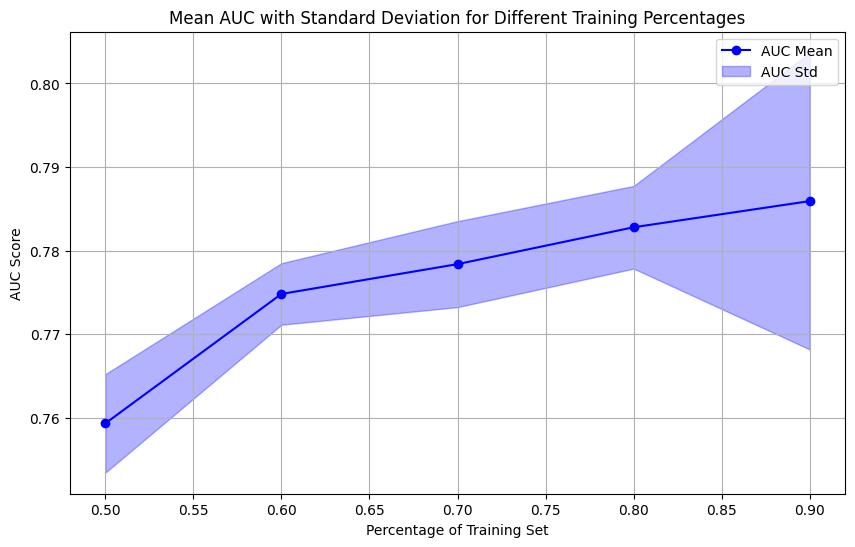

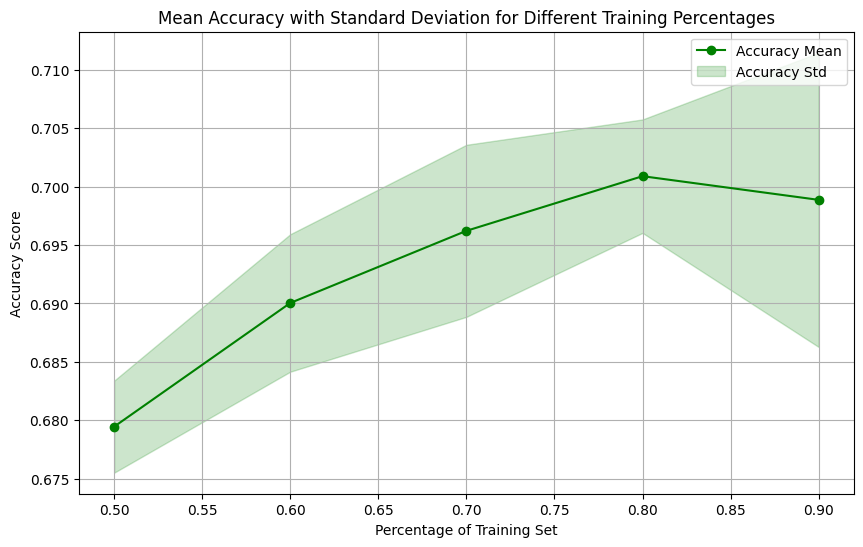

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(percentages, test_accuracy_auc_mean, label='AUC Mean', color='blue', marker='o')
plt.fill_between(percentages, 
                 np.array(test_accuracy_auc_mean) - np.array(test_accuracy_auc_std),
                 np.array(test_accuracy_auc_mean) + np.array(test_accuracy_auc_std),
                 color='blue', alpha=0.3, label='AUC Std')
plt.xlabel('Percentage of Training Set')
plt.ylabel('AUC Score')
plt.title('Mean AUC with Standard Deviation for Different Training Percentages')
plt.grid(True)
plt.legend()

# Plotting Accuracy results with shaded standard deviation area
plt.figure(figsize=(10, 6))
plt.plot(percentages, test_accuracy_acc_mean, label='Accuracy Mean', color='green', marker='o')
plt.fill_between(percentages, 
                 np.array(test_accuracy_acc_mean) - np.array(test_accuracy_acc_std),
                 np.array(test_accuracy_acc_mean) + np.array(test_accuracy_acc_std),
                 color='green', alpha=0.2, label='Accuracy Std')
plt.xlabel('Percentage of Training Set')
plt.ylabel('Accuracy Score')
plt.title('Mean Accuracy with Standard Deviation for Different Training Percentages')
plt.grid(True)
plt.legend()

Complessicvamente siamo convinti delle curve di accuracy? C'è qualche errore nella computazione?

## TENTATIVO HEAT MAP

In [15]:
def evaluate_model(hidden_channels, out_channels):
    model = Net(dataset.num_features, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    val_history, auc_history, loss_history, final_test_auc, final_test_acc, train_accuracy_history = train_model(train_data, val_data, test_data, epochs=300)

    return final_test_auc, final_test_acc  

In [16]:
hidden_units = [32, 64, 128, 256]
output_units = [16, 32, 64, 128]

results_matrix = np.zeros((len(hidden_units), len(output_units)))


for i, hidden in enumerate(hidden_units):
    for j, output in enumerate(output_units):
        auc, _ = evaluate_model(hidden, output)
        results_matrix[i, j] = auc
        print(f"Hidden units: {hidden}, Output units: {output} -> AUC: {auc:.4f}")


Epoch 1/300
Training completed in 0.0930 seconds.
Validation completed in 0.0210 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8931, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0700 seconds.
Validation completed in 0.0190 seconds.
Epoch: 002, Loss: 0.6888, Train Acc: 0.5000, Val AUC: 0.8911, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0750 seconds.
Validation completed in 0.0199 seconds.
Epoch: 003, Loss: 0.6725, Train Acc: 0.5119, Val AUC: 0.8916, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0681 seconds.
Validation completed in 0.0190 seconds.
Epoch: 004, Loss: 0.6639, Train Acc: 0.8251, Val AUC: 0.8928, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0710 seconds.
Validation completed in 0.0190 seconds.
Epoch: 005, Loss: 0.6557, Train Acc: 0.8371, Val AUC: 0.8889, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0690 seconds.
Validation completed in 0.0190 seconds.
Epoch: 006, Loss: 0.6507, Train Acc: 0.6978, Val AUC: 0.8817, Val ACC:

Text(0.5, 1.0, 'AUC for different configurations of Hidden and Output Units')

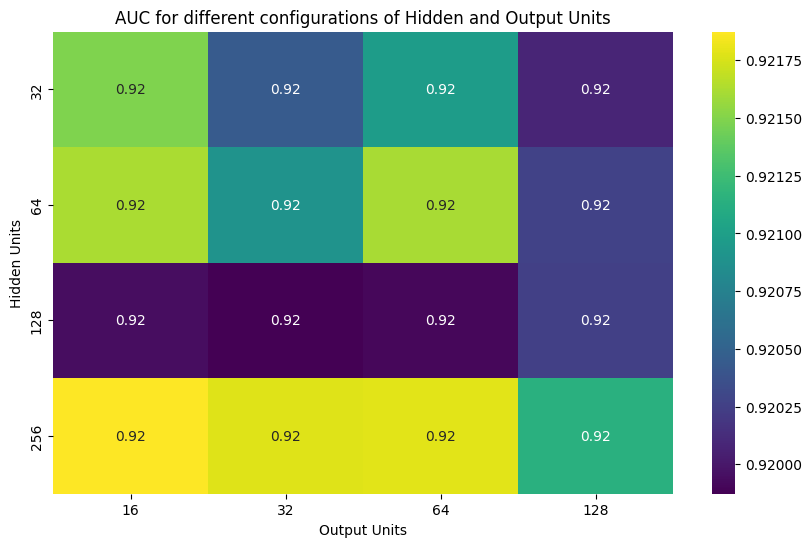

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(results_matrix, annot=True, xticklabels=output_units, yticklabels=hidden_units, cmap='viridis')
plt.xlabel('Output Units')
plt.ylabel('Hidden Units')
plt.title('AUC for different configurations of Hidden and Output Units')

In [18]:
hidden_units = [32, 64, 128, 256]
output_units = [16, 32, 64, 128]

results_matrix = np.zeros((len(hidden_units), len(output_units)))


for i, hidden in enumerate(hidden_units):
    for j, output in enumerate(output_units):
        _, acc = evaluate_model(hidden, output)
        results_matrix[i, j] = auc
        print(f"Hidden units: {hidden}, Output units: {output} -> AUC: {auc:.4f}")


Epoch 1/300
Training completed in 0.2785 seconds.
Validation completed in 0.0820 seconds.
Epoch: 001, Loss: 0.4822, Train Acc: 0.8500, Val AUC: 0.9188, Val ACC: 0.7362
Epoch 2/300
Training completed in 0.2520 seconds.
Validation completed in 0.0830 seconds.
Epoch: 002, Loss: 0.4811, Train Acc: 0.8497, Val AUC: 0.9189, Val ACC: 0.7362
Epoch 3/300
Training completed in 0.2530 seconds.
Validation completed in 0.0820 seconds.
Epoch: 003, Loss: 0.4830, Train Acc: 0.8480, Val AUC: 0.9194, Val ACC: 0.7344
Epoch 4/300
Training completed in 0.2360 seconds.
Validation completed in 0.0770 seconds.
Epoch: 004, Loss: 0.4824, Train Acc: 0.8481, Val AUC: 0.9193, Val ACC: 0.7349
Epoch 5/300
Training completed in 0.2670 seconds.
Validation completed in 0.0796 seconds.
Epoch: 005, Loss: 0.4814, Train Acc: 0.8497, Val AUC: 0.9198, Val ACC: 0.7353
Epoch 6/300
Training completed in 0.2330 seconds.
Validation completed in 0.0840 seconds.
Epoch: 006, Loss: 0.4816, Train Acc: 0.8474, Val AUC: 0.9197, Val ACC:

Text(0.5, 1.0, 'ACC for different configurations of Hidden and Output Units')

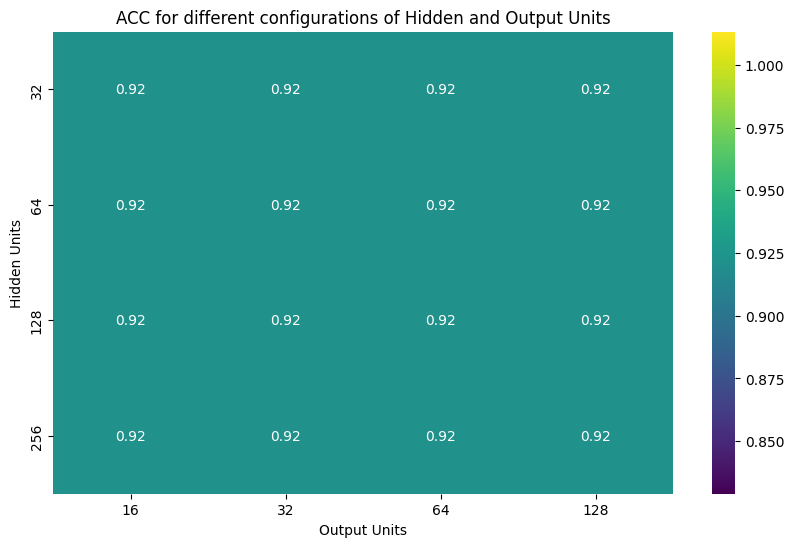

In [19]:
plt.figure(figsize=(10, 6))
sns.heatmap(results_matrix, annot=True, xticklabels=output_units, yticklabels=hidden_units, cmap='viridis')
plt.xlabel('Output Units')
plt.ylabel('Hidden Units')
plt.title('ACC for different configurations of Hidden and Output Units')

Epoch 1/300
Training completed in 0.2750 seconds.
Validation completed in 0.0790 seconds.
Epoch: 001, Loss: 0.4800, Train Acc: 0.8537, Val AUC: 0.9192, Val ACC: 0.7369
Epoch 2/300
Training completed in 0.2498 seconds.
Validation completed in 0.0778 seconds.
Epoch: 002, Loss: 0.4810, Train Acc: 0.8509, Val AUC: 0.9209, Val ACC: 0.7319
Epoch 3/300
Training completed in 0.2240 seconds.
Validation completed in 0.0775 seconds.
Epoch: 003, Loss: 0.4809, Train Acc: 0.8484, Val AUC: 0.9197, Val ACC: 0.7367
Epoch 4/300
Training completed in 0.2230 seconds.
Validation completed in 0.0840 seconds.
Epoch: 004, Loss: 0.4832, Train Acc: 0.8482, Val AUC: 0.9175, Val ACC: 0.7367
Epoch 5/300
Training completed in 0.2420 seconds.
Validation completed in 0.0780 seconds.
Epoch: 005, Loss: 0.4828, Train Acc: 0.8529, Val AUC: 0.9201, Val ACC: 0.7349
Epoch 6/300
Training completed in 0.2290 seconds.
Validation completed in 0.0780 seconds.
Epoch: 006, Loss: 0.4815, Train Acc: 0.8495, Val AUC: 0.9210, Val ACC:

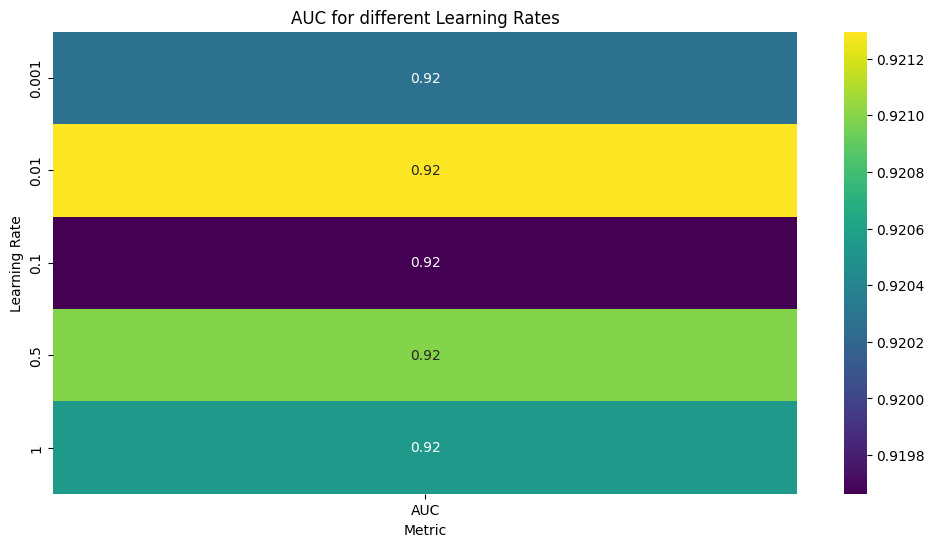

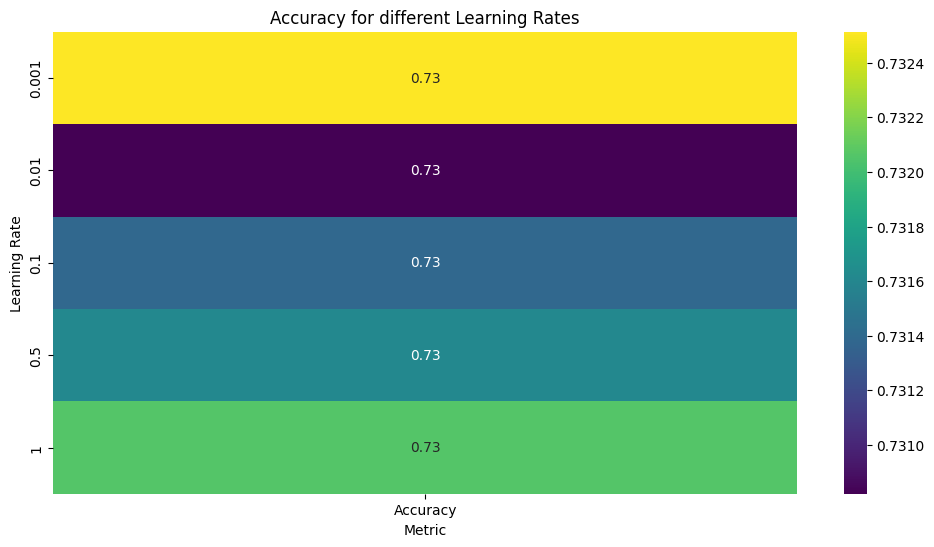

In [20]:
learning_rates = [0.001, 0.01, 0.1, 0.5, 1]

results_matrix = np.zeros((len(learning_rates), 2)) 

def evaluate_model(learning_rate):
    model = Net(dataset.num_features, 128, 64).to(device)  
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Allenamento del modello
    val_history, auc_history, loss_history, final_test_auc, final_test_acc, train_accuracy_history = train_model(train_data, val_data, test_data, epochs=300)

    return final_test_auc, final_test_acc 


for i, lr in enumerate(learning_rates):
    auc, acc = evaluate_model(lr)
    results_matrix[i, 0] = auc  # AUC
    results_matrix[i, 1] = acc  # Accuracy
    print(f"Learning rate: {lr} -> AUC: {auc:.4f}, Accuracy: {acc:.4f}")


plt.figure(figsize=(12, 6))
sns.heatmap(results_matrix[:, 0].reshape(-1, 1), annot=True, xticklabels=['AUC'], yticklabels=learning_rates, cmap='viridis')
plt.title('AUC for different Learning Rates')
plt.xlabel('Metric')
plt.ylabel('Learning Rate')
plt.show()


plt.figure(figsize=(12, 6))
sns.heatmap(results_matrix[:, 1].reshape(-1, 1), annot=True, xticklabels=['Accuracy'], yticklabels=learning_rates, cmap='viridis')
plt.title('Accuracy for different Learning Rates')
plt.xlabel('Metric')
plt.ylabel('Learning Rate')
plt.show()


I prossimi step sono:
- vedere come le dimensioni dell reti convoluzionarie influiscono sul training, 2D heatmap
- approfondire meglio il negative sampling che non ho capito onestamente
- trovare metodi per capire se si sta overfittando o meno
- runnare per capire quante feature per nodo sono necessarie per ottenere una accuracy accettabile
- fare classi per il training
- fare una grande run con la corruption
- sistemare alcune funzioni siccome chiamano cose globali all'interno di funzioni singole, tra cui passare optimizer e loss nelle funzioni di training

Prima però è da verificare che:
- le curve delle accuracy abbiano senso
- lo scaling con la percentuale di noti nel training set sia corretta
- la gradient propagation sia 
- a giudicare la heat map che sembra strana